In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [ ]:
import viser
server = viser.ViserServer()

In [3]:

intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=75.0, fy=75.0,
    cx=50.0, cy=50.0,
    near=0.001, far=16.0
)
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
jax_renderer = JaxRenderer(intrinsics)


In [21]:

import trimesh
def as_mesh(scene_or_mesh):
    """
    Convert a possible scene to a mesh.

    If conversion occurs, the returned mesh has only vertex and face data.
    """
    if isinstance(scene_or_mesh, trimesh.Scene):
        if len(scene_or_mesh.geometry) == 0:
            mesh = None  # empty scene
        else:
            # we lose texture information here
            mesh = trimesh.util.concatenate(
                tuple(trimesh.Trimesh(vertices=g.vertices, faces=g.faces)
                    for g in scene_or_mesh.geometry.values()))
    else:
        assert(isinstance(mesh, trimesh.Trimesh))
        mesh = scene_or_mesh
    return mesh
mesh  =as_mesh(trimesh.load('InteriorTest.obj'))
mesh.vertices  = mesh.vertices * jnp.array([1.0, -1.0, 1.0]) + jnp.array([0.0, 1.0, 0.0])
vertices = mesh.vertices
faces = mesh.faces
print(b.utils.aabb(mesh.vertices))
b.show_trimesh("1",mesh)

(Array([5.190015, 3.000812, 8.171652], dtype=float32), Array([[ 1.        ,  0.        ,  0.        , -0.09099948],
       [ 0.        ,  1.        ,  0.        , -0.49959397],
       [ 0.        ,  0.        ,  1.        , -0.01582694],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32))


In [22]:
server.add_mesh_trimesh(
    name="/trimesh",
    mesh=mesh,
)

GlbHandle(_impl=_SceneNodeHandleState(name='/trimesh', api=<viser._viser.ViserServer object at 0x7fe774445c10>, wxyz=array([1., 0., 0., 0.]), position=array([0., 0., 0.]), visible=True, click_cb=None))

In [23]:
def apply_move(pose, move):
    if move == "ahead":
        return pose @ b.transform_from_pos(jnp.array([0.0, 0.0, 0.1]))
    elif move == "right":
        return pose @ b.transform_from_pos(jnp.array([0.1, 0.0, 0.0]))
    elif move == "left":
        return pose @ b.transform_from_pos(jnp.array([-0.1, 0.0, 0.0]))
    elif move == "rotate_left":
        return pose @ b.transform_from_axis_angle(jnp.array([-0.0, 1.0, 0.0]), jnp.deg2rad(10.0) * -1.0)
    elif move == "rotate_right":
        return pose @ b.transform_from_axis_angle(jnp.array([-0.0, 1.0, 0.0]), jnp.deg2rad(10.0) * 1.0)
moves = [*["ahead" for _ in range(20)], *["rotate_left" for _ in range(8)], *["ahead" for _ in range(10)], *["rotate_right" for _ in range(4)],*["ahead" for _ in range(10)]]
camera_poses = [jnp.eye(4)]
for move in moves:
    camera_poses.append(apply_move(camera_poses[-1], move))
camera_poses = jnp.stack(camera_poses)

In [24]:
gt_images = [
    jax_renderer.render(vertices, faces, b.inverse_pose(p), intrinsics)[0][0,...]
    for p in camera_poses
]


In [7]:
b.make_gif_from_pil_images([b.get_depth_image(img, min_val=0.0, remove_max=False) for img in gt_images], "gt.gif")

In [8]:
def loss(trans, q, gt_img):
    camera_pose = b.translation_and_quaternion_to_pose_matrix(trans, q)
    img = jax_renderer.render(vertices, faces, b.inverse_pose(camera_pose), intrinsics)[0][0,...]
    return (jnp.abs(img - gt_img)).mean()

value_and_grad_jit = jax.jit(jax.value_and_grad(loss, argnums=(0,1,)))

In [11]:
b.clear_visualizer()
b.show_pose("actual", camera_poses[1])
tr,q = b.pose_matrix_to_translation_and_quaternion(camera_poses[0])
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)

In [12]:
print("start " , value_and_grad_jit(tr, q, gt_images[1]))
poses = []
pbar = tqdm(range(200))
timestep = 1
for _  in pbar:
    loss, (g1, g2) = value_and_grad_jit(tr, q, gt_images[timestep])
    tr -= g1 * 0.01
    q -= g2 * 0.01
    pbar.set_description(f"{loss}")
    # poses.append(b.translation_and_quaternion_to_pose_matrix(tr,q))
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)

start  (Array(0.48633558, dtype=float32), (Array([-0.01954   ,  0.06823303, -0.45479128], dtype=float32), Array([ 0.        ,  1.025517  , -0.06746437, -0.06139864], dtype=float32)))


0.11390623450279236: 100%|██████████| 200/200 [00:00<00:00, 366.14it/s] 


In [14]:
b.clear_visualizer()
b.show_pose("actual", camera_poses[1])
tr,q = b.pose_matrix_to_translation_and_quaternion(camera_poses[0])
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)
inferred_poses = []
pbar2 = tqdm(range(len(gt_images)))
for timestep  in pbar2:
    pbar = tqdm(range(50))
    for _  in pbar:
        loss, (g1, g2) = value_and_grad_jit(tr, q, gt_images[timestep])
        tr -= g1 * 0.01
        q -= g2 * 0.01
        pbar.set_description(f"{loss}")
    b.show_pose("actual", camera_poses[timestep])
    b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)
    inferred_poses.append(b.translation_and_quaternion_to_pose_matrix(tr,q))
inferred_poses = jnp.stack(inferred_poses)

  0%|          | 0/53 [00:00<?, ?it/s]

100%|██████████| 53/53 [00:10<00:00,  4.84it/s]


100%|██████████| 53/53 [00:13<00:00,  3.98it/s]


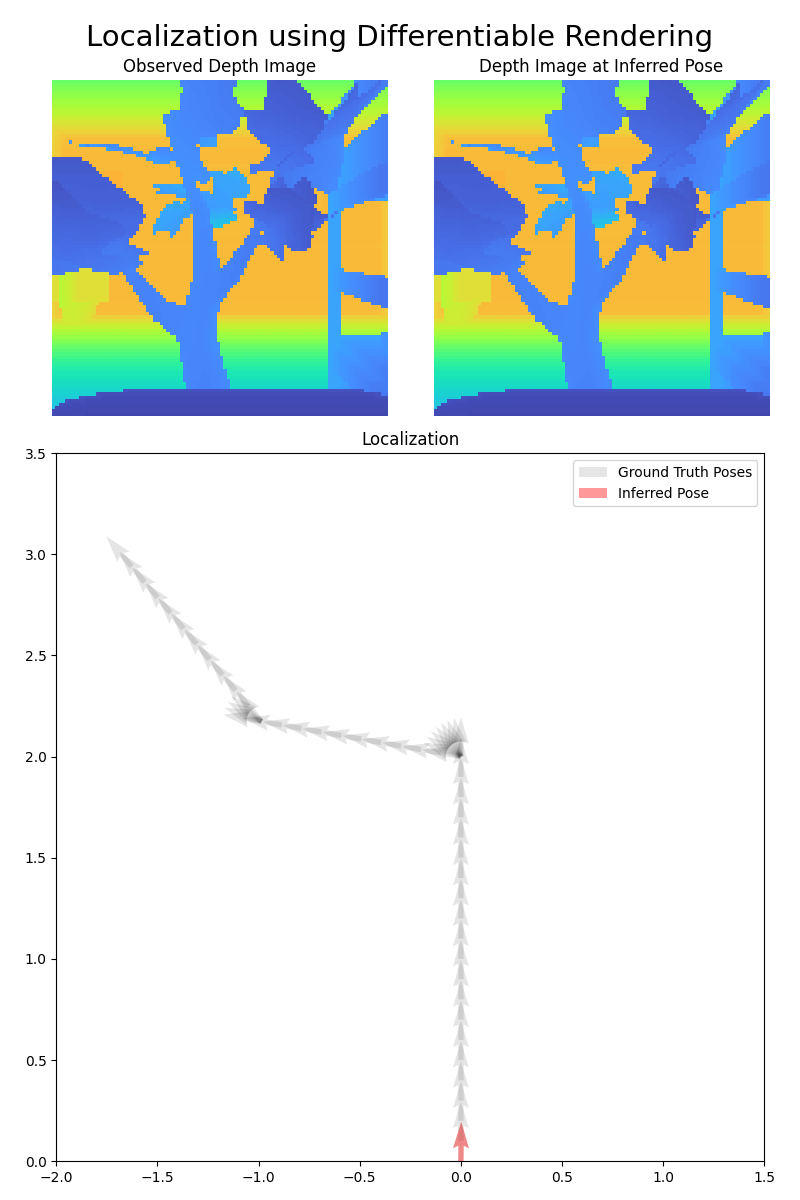

In [15]:
buffs = []
for i in tqdm(range(len(inferred_poses))):
# for i in tqdm(range(1)):
    fig = plt.figure(figsize=(8,12))
    fig.suptitle("Localization using Differentiable Rendering", fontsize=21)
    # fig = plt.figure()
    gs = gridspec.GridSpec(3, 2)

    ax = fig.add_subplot(gs[0,0])
    ax.imshow(np.array(b.get_depth_image(gt_images[i], min_val=0.0, max_val=5.0, remove_max=False)))
    ax.set_title("Observed Depth Image")
    ax.axis("off")
    ax = fig.add_subplot(gs[0,1])
    camera_pose_inferred = inferred_poses[i]
    img = jax_renderer.render(vertices, faces, b.inverse_pose(camera_pose_inferred), intrinsics)[0][0,...]
    ax.imshow(np.array(b.get_depth_image(gt_images[i], min_val=0.0, max_val=5.0, remove_max=False)))
    ax.set_title("Depth Image at Inferred Pose")
    ax.axis("off")

    ax = fig.add_subplot(gs[1:,:])
    length = 0.2
    ax.quiver(camera_poses[:,0,3], camera_poses[:,2,3], camera_poses[:,0,2]*length, camera_poses[:,2,2]*length, angles="xy", color="black", label="Ground Truth Poses", alpha=0.1)
    length = 0.05
    ax.quiver(inferred_poses[i,0,3], inferred_poses[i,2,3], inferred_poses[i,0,2]*length, inferred_poses[i,2,2]*length, angles="xy", color="red", label="Inferred Pose", alpha=0.4)
    ax.set_xlim(-2.0, 1.5)
    ax.set_ylim(0.0, 3.5)
    ax.set_aspect("equal")
    ax.legend()
    ax.set_title("Localization")
    fig.tight_layout()
    fig.canvas.draw()
    plt.close()
    buffs.append(b.pil_image_from_matplotlib(fig))
buffs[0]

In [16]:
b.make_gif_from_pil_images(buffs, "inferred.gif")
import subprocess
fps = 3.0
for i in range(len(buffs)):
    buffs[i].convert("RGB").save("%07d.png" % i)
subprocess.call(["ffmpeg","-y","-r",str(fps),"-i", "%07d.png","localization_with_gradients.mp4"])

ffmpeg version 4.3.6-0+deb11u1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

0

╭─────────────── viser ───────────────╮
│             ╷                       │
│   HTTP      │ http://0.0.0.0:8081   │
│   Websocket │ ws://0.0.0.0:8081     │
│             ╵                       │
╰─────────────────────────────────────╯

(viser) Connection opened (0, 1 total), 3 persistent messages

In [ ]:
server.add_tr

In [95]:
VISUALIZER.save_image()

AttributeError: 'Visualizer' object has no attribute 'save_image'